In [283]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, learning_curve, cross_val_score, ShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import kaggle
%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('display.max_columns', 100)

In [284]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

all_data = pd.concat([df_train, df_test], ignore_index=True)
all_data['SalePrice'].fillna(0, inplace=True)
original_data = all_data.copy()
all_data.drop(['Id'], axis=1, inplace=True)

print('Train Set: {}, {}'.format(df_train.shape[0], df_train.shape[1]))
print('Test Set: {}, {}'.format(df_test.shape[0], df_test.shape[1]))
print('All Data: {}, {}'.format(all_data.shape[0], all_data.shape[1]))

submission = pd.DataFrame(columns=['Id', 'SalePrice'])
submission['Id'] = df_test['Id']
submission['SalePrice'] = 0

Train Set: 1460, 81
Test Set: 1459, 80
All Data: 2919, 80


In [285]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

In [286]:
# According to Data Description some datatypes are incorrect so lets fix them. 
# MSSubClass, OverallQual and OverallCond are, actually, categorical.
for feature in ['MSSubClass', 'OverallQual', 'OverallCond']:
    all_data[feature] = all_data[feature].astype('object')

In [287]:
all_data[all_data['SalePrice'] > 0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0
2ndFlrSF,1460.0,346.992466,436.528436,0.0,0.00,0.0,728.00,2065.0
3SsnPorch,1460.0,3.409589,29.317331,0.0,0.00,0.0,0.00,508.0
BedroomAbvGr,1460.0,2.866438,0.815778,0.0,2.00,3.0,3.00,8.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtFullBath,1460.0,0.425342,0.518911,0.0,0.00,0.0,1.00,3.0
BsmtHalfBath,1460.0,0.057534,0.238753,0.0,0.00,0.0,0.00,2.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
EnclosedPorch,1460.0,21.954110,61.119149,0.0,0.00,0.0,0.00,552.0


## Outlier Detection

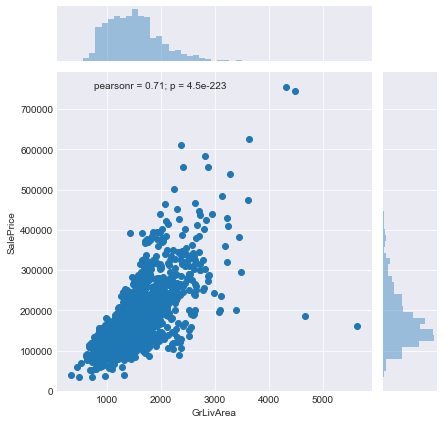

In [288]:
sns.jointplot(data=all_data[all_data['SalePrice'] > 0], x='GrLivArea', y='SalePrice')

In [289]:
all_data[(all_data['SalePrice'] > 0) & (all_data['GrLivArea'] > 4000)]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
523,3138,1538,0,NaN,3,1Fam,TA,Gd,2260.0,0.0,GLQ,Unf,1.0,0.0,Ex,878.0,Y,PosN,PosN,SBrkr,0,TA,Ex,CemntBd,CmentBd,NaN,Gd,1,PConc,3,Typ,884.0,3.0,TA,Fin,TA,BuiltIn,2007.0,4676,1,GasA,Ex,2Story,1,Ex,Bnk,Gtl,40094,Inside,130.0,IR1,0,60,RL,762.0,Stone,NaN,0,10,Edwards,406,5,10,Y,0,NaN,CompShg,Hip,Partial,184750.0,New,0,Pave,11,3138.0,AllPub,208,2007,2008,2007
691,2444,1872,0,NaN,4,1Fam,TA,Gd,1455.0,0.0,GLQ,Unf,0.0,1.0,Ex,989.0,Y,Norm,Norm,SBrkr,0,TA,Ex,HdBoard,HdBoard,NaN,Ex,2,PConc,3,Typ,832.0,3.0,TA,Fin,TA,Attchd,1994.0,4316,1,GasA,Ex,2Story,1,Ex,Lvl,Gtl,21535,Corner,104.0,IR1,0,60,RL,1170.0,BrkFace,NaN,0,1,NoRidge,50,6,10,Y,0,NaN,WdShngl,Gable,Normal,755000.0,WD,0,Pave,10,2444.0,AllPub,382,1994,1995,2007
1182,2411,2065,0,NaN,4,1Fam,TA,Av,2096.0,0.0,GLQ,Unf,1.0,0.0,Ex,300.0,Y,Norm,Norm,SBrkr,0,TA,Gd,Wd Sdng,ImStucc,MnPrv,TA,2,PConc,3,Typ,813.0,3.0,TA,Fin,TA,Attchd,1996.0,4476,1,GasA,Ex,2Story,1,Ex,Lvl,Gtl,15623,Corner,160.0,IR1,0,60,RL,0.0,None,NaN,0,7,NoRidge,78,5,10,Y,555,Ex,CompShg,Hip,Abnorml,745000.0,WD,0,Pave,10,2396.0,AllPub,171,1996,1996,2007
1298,4692,950,0,NaN,3,1Fam,TA,Gd,5644.0,0.0,GLQ,Unf,2.0,0.0,Ex,466.0,Y,Feedr,Norm,SBrkr,0,TA,Ex,Stucco,Stucco,NaN,Gd,3,PConc,2,Typ,1418.0,2.0,TA,Fin,TA,Attchd,2008.0,5642,1,GasA,Ex,2Story,1,Ex,Bnk,Gtl,63887,Corner,313.0,IR3,0,60,RL,796.0,Stone,NaN,0,1,Edwards,292,5,10,Y,480,Gd,ClyTile,Hip,Partial,160000.0,New,0,Pave,12,6110.0,AllPub,214,2008,2008,2008


In [290]:
# Well, these houses can be considered outliers.
all_data.drop(all_data[(all_data['SalePrice'] > 0) & (all_data['GrLivArea'] > 4000)].index, inplace=True)

----

## Missing Values

In [291]:
def missing_ratio(df):
    missing = (df.isnull().sum() / df.shape[0]) * 100
    df_nulls = pd.DataFrame(data={'Column': missing.index.values, 'Count': df.isnull().sum().values, 'Ratio': missing.values})
    df_nulls.sort_values(by='Ratio', ascending=False, inplace=True)
    return df_nulls

In [292]:
null_ratios = missing_ratio(all_data)
null_ratios[null_ratios['Count'] > 0]

,Column,Count,Ratio
65,PoolQC,2907,99.725557
56,MiscFeature,2810,96.397942
3,Alley,2717,93.207547
25,Fence,2345,80.445969
26,FireplaceQu,1420,48.713551
49,LotFrontage,486,16.672384
37,GarageYrBlt,159,5.454545
35,GarageQual,159,5.454545
34,GarageFinish,159,5.454545
33,GarageCond,159,5.454545


### LotFrontage

In [293]:
by_neighbor = all_data.groupby(by='Neighborhood', sort=True)
by_neighbor.median()['LotFrontage']

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    64.5
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    88.5
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [294]:
# Replace the NaN's in LotFrontage with the neighborhood's median.
def neighborhood_median(row):
    median = by_neighbor['LotFrontage'].median()[row['Neighborhood']]
    return median

all_data['LotFrontage'] = all_data.apply(lambda row: neighborhood_median(row) if np.isnan(row['LotFrontage']) else row['LotFrontage'], axis=1)

In [295]:
# Numeric features...
all_data.fillna({'GarageArea': 0, 
                 'GarageCars': 0,
                 'TotalBsmtSF': 0,
                 'BsmtFullBath': 0,
                 'BsmtHalfBath': 0,
                 'BsmtFinSF1': 0,
                 'BsmtFinSF2': 0,
                 'BsmtUnfSF': 0,
                 'MasVnrArea': 0, 
                 'MasVnrType': 'None'}, inplace=True)

# Columns that are going to be filled with the mode.
mode_columns = ['Electrical', 'MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual']
for col in mode_columns:
    all_data.fillna({col: all_data[col].mode()[0]}, inplace=True)    

# Replace GarageCond, GarageType, GarageFinish, GarageQual and GarageYrBlt "NaN's" with "NA" when GarageArea = 0;
mask = (all_data['GarageArea'] == 0)
all_data.loc[mask, ['GarageCond','GarageType','GarageFinish','GarageQual','GarageYrBlt']] = "NA"

# Replace GarageCond, GarageType, GarageFinish, GarageQual and GarageYrBlt "NaN's" with "None" when GarageArea > 0;
mask = (all_data['GarageArea'] > 0)
all_data.loc[mask, ['GarageCond','GarageType','GarageFinish','GarageQual','GarageYrBlt']] = "None"

# Replace BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2 and BsmtExposure "NaN's" with "NA" when TotalBsmtSF = 0;
mask = (all_data['TotalBsmtSF'] == 0)
all_data.loc[mask, ['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure']] = "NA"

# Replace BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2 and BsmtExposure "NaN's" with "None" when TotalBsmtSF > 0;
mask = (all_data['TotalBsmtSF'] > 0)
all_data.loc[mask, ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure']] = "None"

`PoolQC`, `MiscFeature`, `Alley`, `Fence` and `FireplaceQu` have too many null values. I'm not inputing these features because an input of more than 50% would distort the feature too much. I also dont think they are so important for the predictions so im just discarding these features

In [296]:
all_data.drop(['PoolQC','MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [297]:
# Checking for remaining NaN's
null_ratios = missing_ratio(all_data)
null_ratios[null_ratios['Count'] > 0]

,Column,Count,Ratio


---

# Exploratory Data Analysis

The objective of this step is to know the data, the relations between the variables and the distributions of the features.

## Numeric Features

### Correlation Matrix

Understand how the features are correlated with the target (SalePrice).

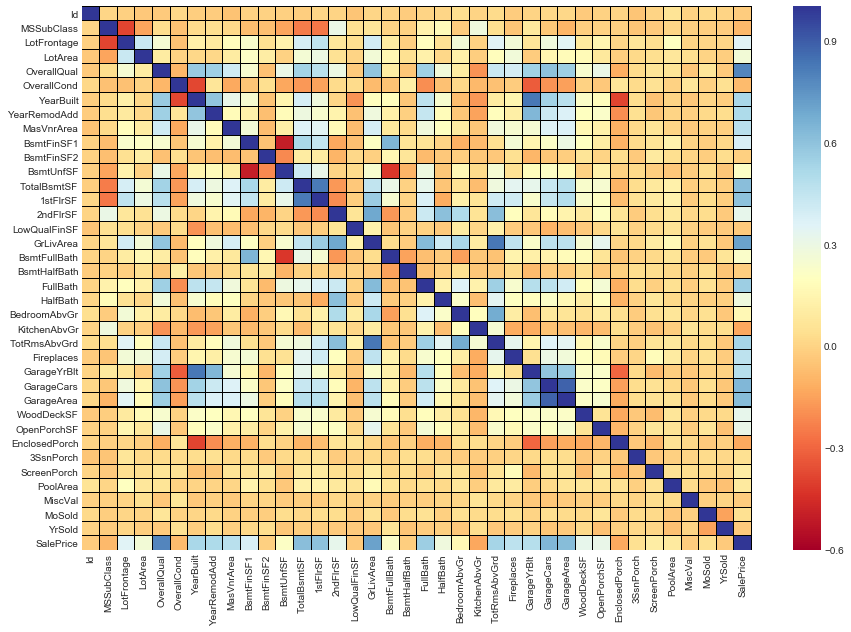

In [298]:
plt.figure(figsize=(15,10))
sns.heatmap(df_train.corr(), cmap='RdYlBu', linewidths=.01, linecolor='black', vmin=-0.6, vmax=1)

- `TotalBsmtSF`, `1stFlrSF`, `GrLivArea`, `GarageCars`, `GarageArea` and `FullBath` are the most correlated features w/ `SalePrice`.
- `TotalBsmtSF` and `1stFlrSF` are strongly correlated.
- `GrLivArea` and `TotRmsAbvGrd` are strongly correlated.
- `GarageCars` and `GarageArea`are strongly correlated.

### LotFrontage

Linear feet of street connected to property.

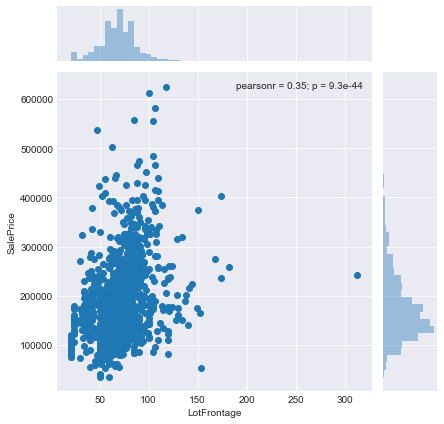

In [299]:
plt.figure(figsize=(10,5))
sns.jointplot(data=all_data[all_data['SalePrice'] > 0], x='LotFrontage', y='SalePrice')

### LotArea

Lot size in square feet.

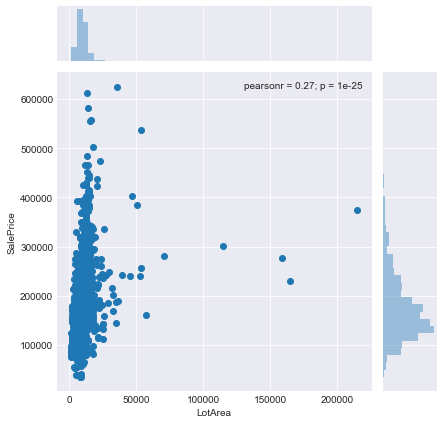

In [300]:
plt.figure(figsize=(10,5))
sns.jointplot(data=all_data[all_data['SalePrice'] > 0], x='LotArea', y='SalePrice')

### YearBuilt

Original construction date.

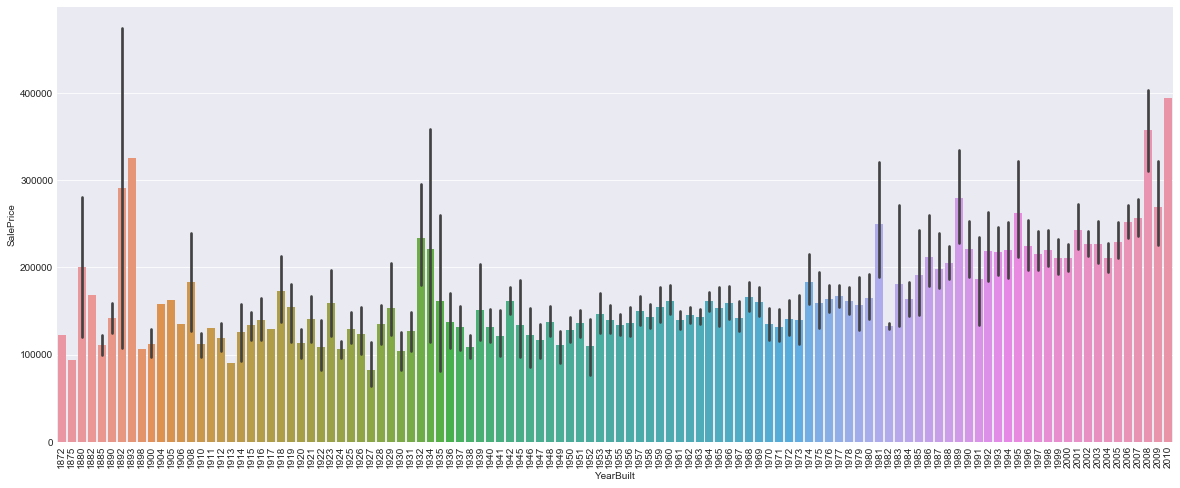

In [301]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.barplot(data=all_data[all_data['SalePrice'] > 0], x='YearBuilt', y='SalePrice')

### Fireplaces

Number of fireplaces.

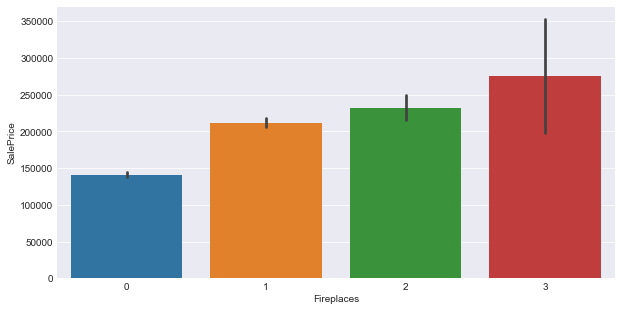

In [302]:
plt.figure(figsize=(10,5))
sns.barplot(data=all_data[all_data['SalePrice'] > 0], x='Fireplaces', y='SalePrice')

### GarageCars

Size of garage in car capacity.

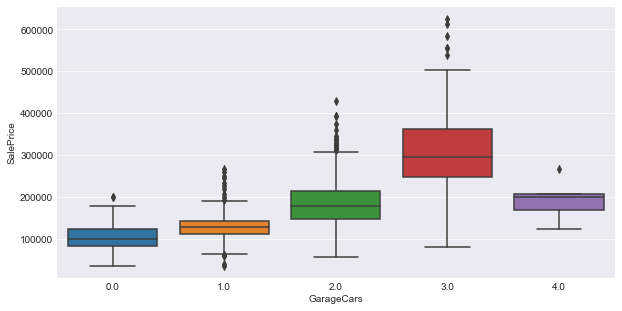

In [303]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='GarageCars', y='SalePrice')

### WoodDeckSF

Wood deck area in square feet.

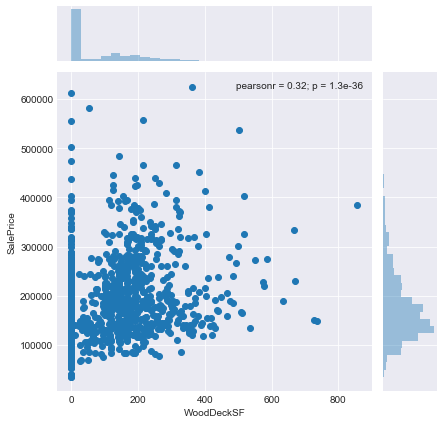

In [304]:
plt.figure(figsize=(10,5))
train_data = all_data[all_data['SalePrice'] > 0]
sns.jointplot(x=train_data['WoodDeckSF'], y=train_data['SalePrice'])

### MiscVal

Value of miscellaneous feature.

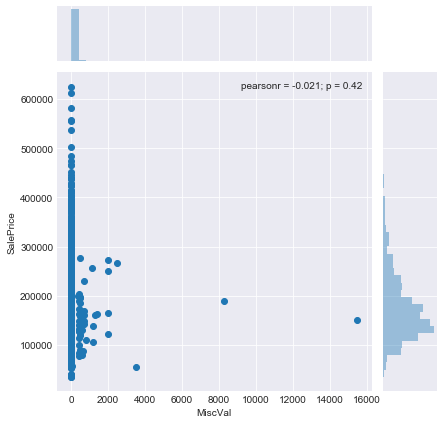

In [305]:
plt.figure(figsize=(10,5))
sns.jointplot(data=all_data[all_data['SalePrice'] > 0], x='MiscVal', y='SalePrice')

---

## Categorical Features

### BldgType

Type of dwelling

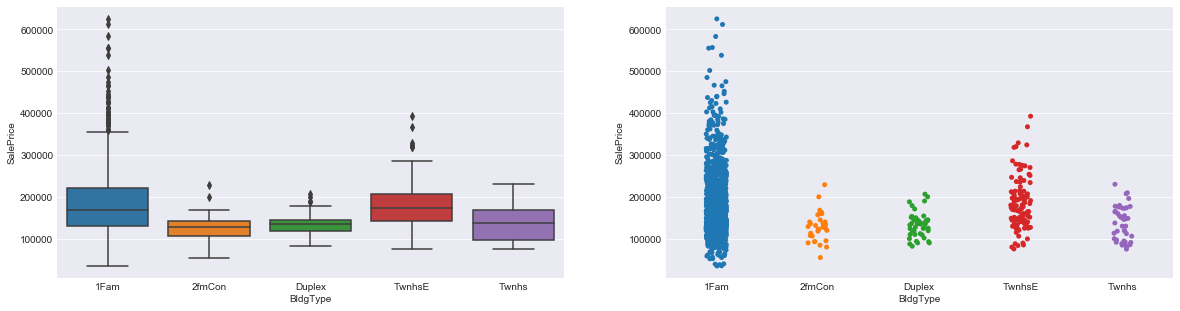

In [318]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='BldgType', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='BldgType', y='SalePrice', jitter=True)

### BsmtCond

Evaluates the general condition of the basement.

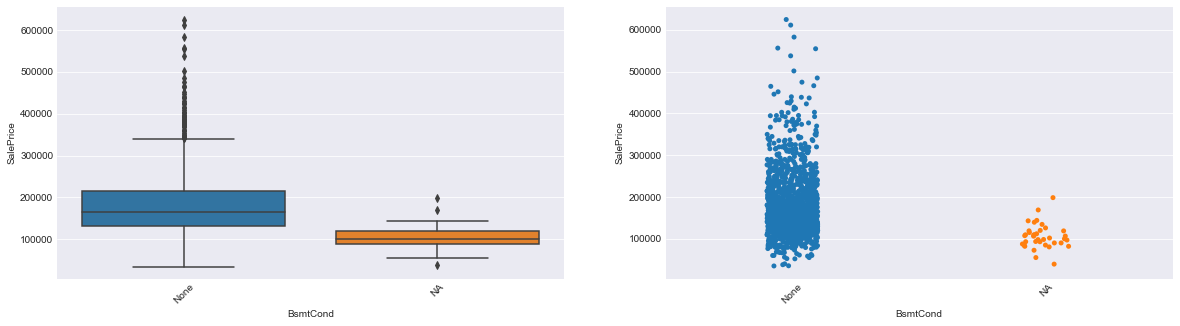

In [309]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='BsmtCond', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='BsmtCond', y='SalePrice', jitter=True)

### BsmtExposure

Refers to walkout or garden level walls.

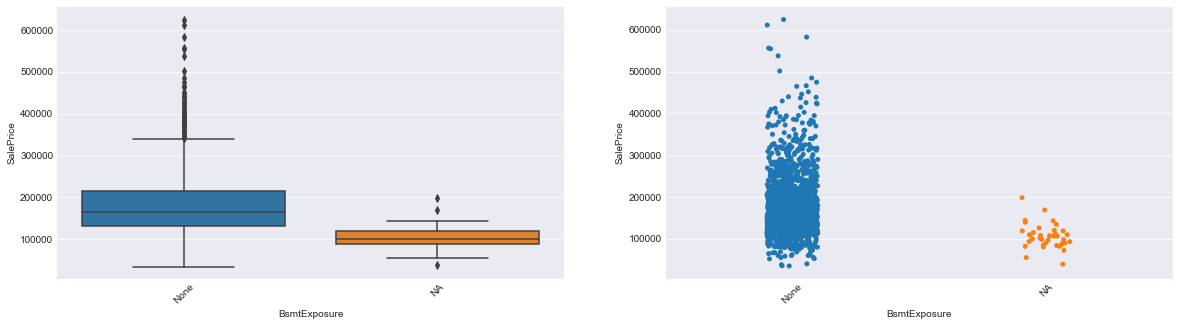

In [311]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='BsmtExposure', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='BsmtExposure', y='SalePrice', jitter=True)

### BsmtFinType1

Rating of basement finished area.

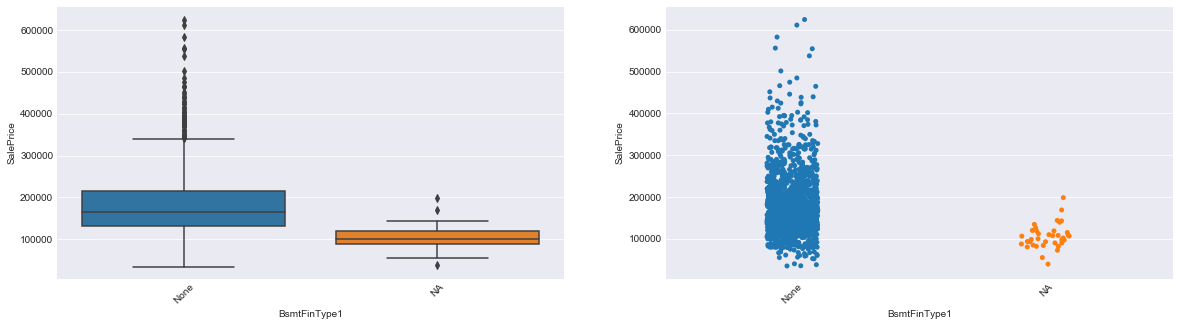

In [312]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='BsmtFinType1', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='BsmtFinType1', y='SalePrice', jitter=True)

### BsmtFinType2

Rating of basement finished area (if multiple types)

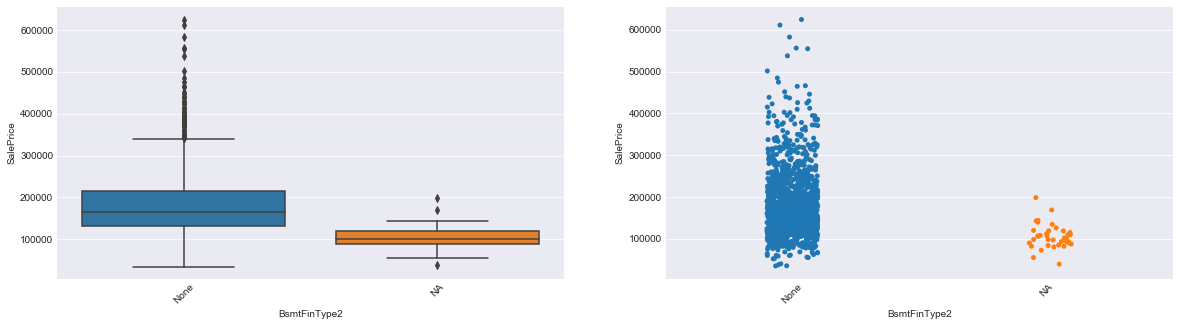

In [313]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='BsmtFinType2', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='BsmtFinType2', y='SalePrice', jitter=True)

### BsmtQual

Evaluates the height of the basement.

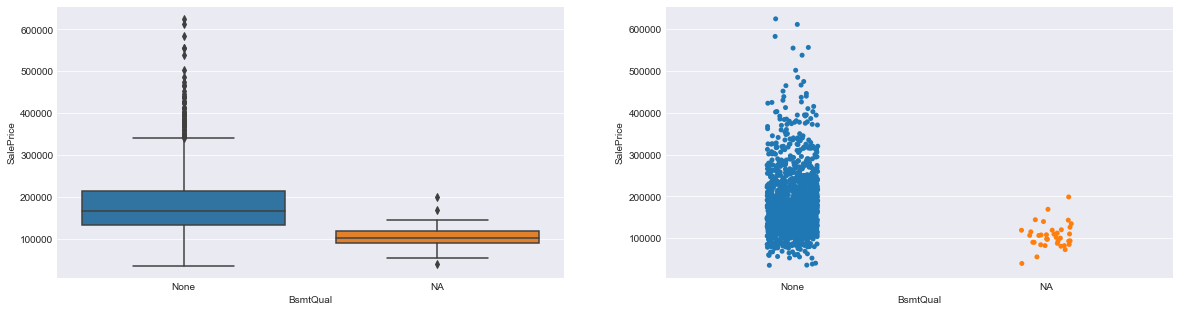

In [317]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='BsmtQual', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='BsmtQual', y='SalePrice', jitter=True)

### CentralAir

Central air conditioning

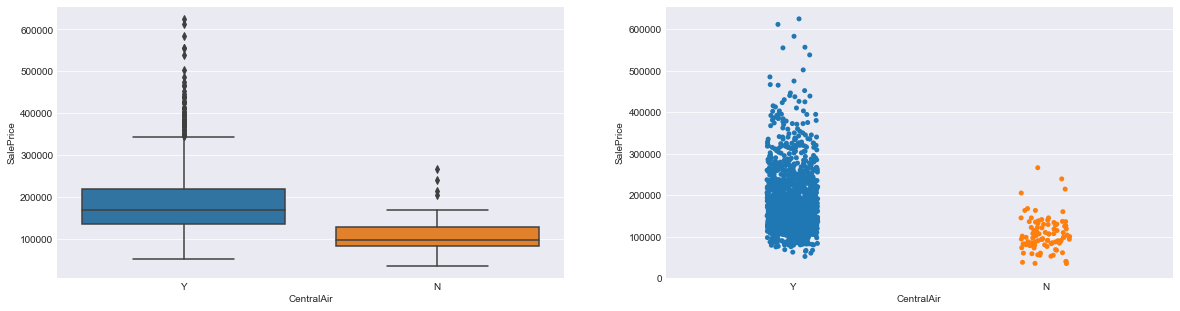

In [217]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='CentralAir', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='CentralAir', y='SalePrice', jitter=True)

- Most of the houses have a CentralAir system, and it increases the house price;
- Since it's a nominal feature, i'm creating dummies;

In [218]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['CentralAir'])

### Condition1

Proximity to various conditions.

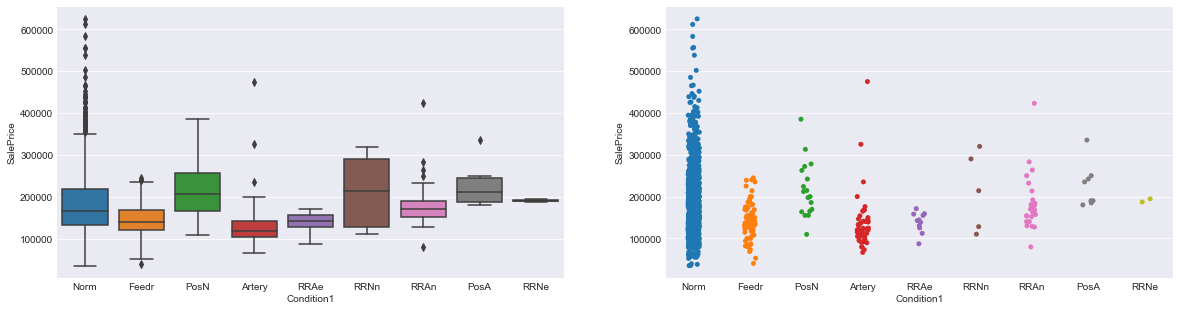

In [319]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Condition1', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='Condition1', y='SalePrice', jitter=True)

### Condition2

Proximity to various conditions (if more than one is present).

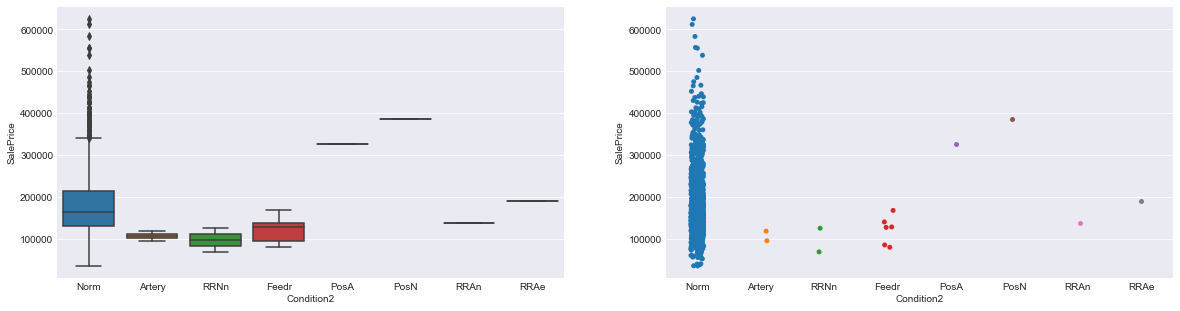

In [320]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Condition2', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='Condition2', y='SalePrice', jitter=True)

### Electrical

Electrical system.

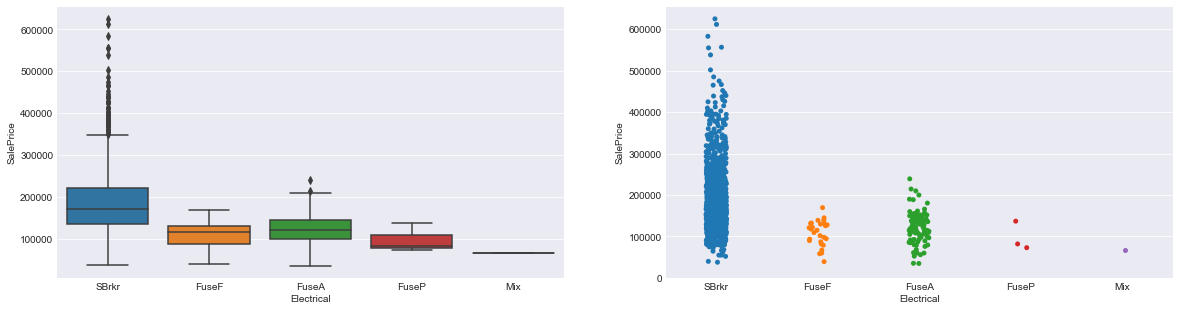

In [321]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Electrical', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='Electrical', y='SalePrice', jitter=True)

### ExterCond

Evaluates the present condition of the material on the exterior.

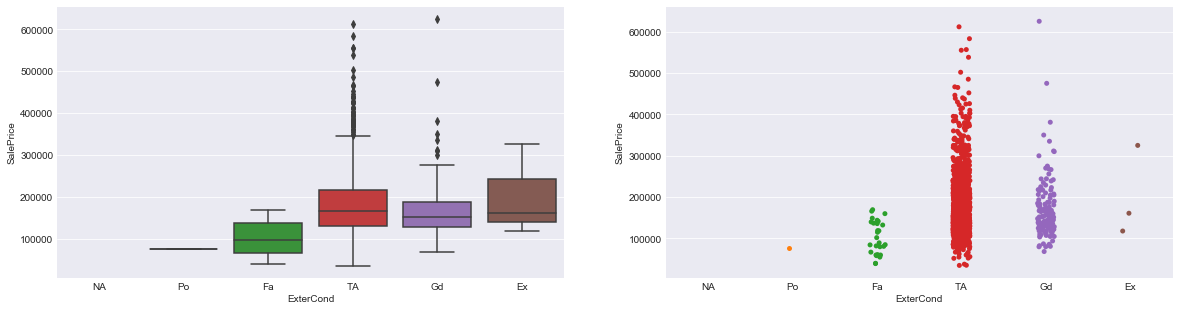

In [339]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='ExterCond', y='SalePrice', order=['NA','Po','Fa','TA','Gd','Ex'])

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='ExterCond', y='SalePrice', order=['NA','Po','Fa','TA','Gd','Ex'], jitter=True)

In [210]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['ExterCond'])

### ExterQual

Evaluates the present condition of the material on the exterior.

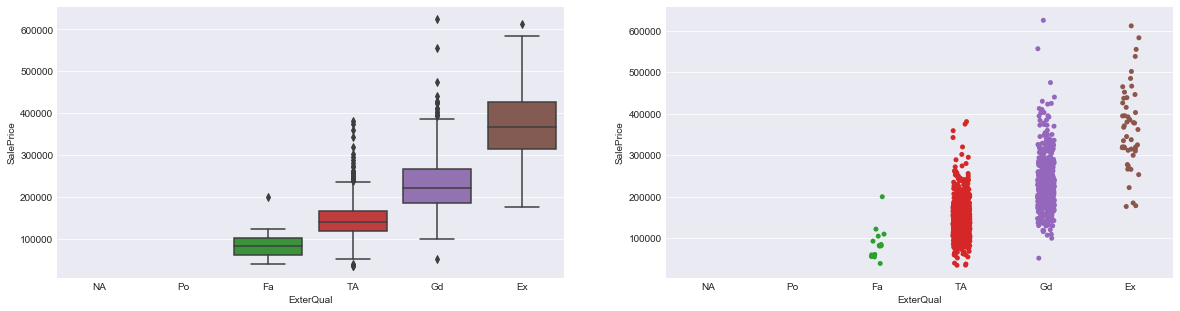

In [355]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='ExterQual', y='SalePrice', order=['NA', 'Po','Fa','TA','Gd','Ex'])

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='ExterQual', y='SalePrice', order=['NA', 'Po','Fa','TA','Gd','Ex'], jitter=True)

### Exterior1st

Exterior covering on house.

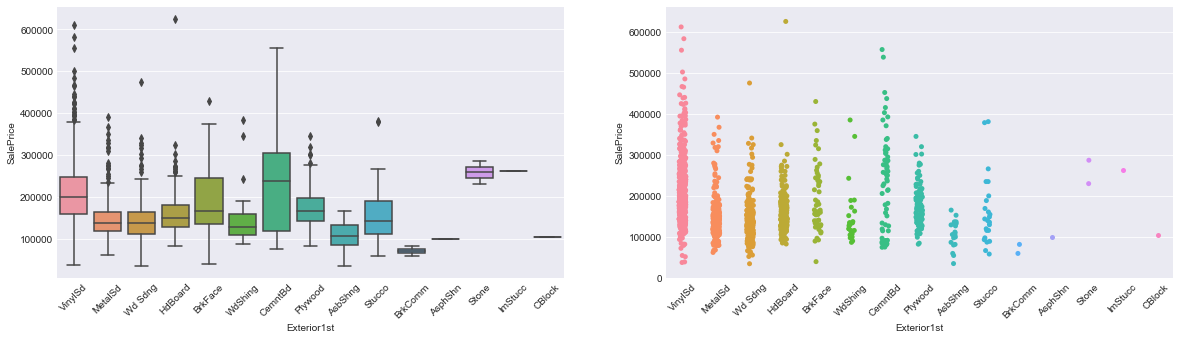

In [354]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Exterior1st', y='SalePrice')

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='Exterior1st', y='SalePrice', jitter=True)

### Exterior2nd

Exterior covering on house (if more than one material).

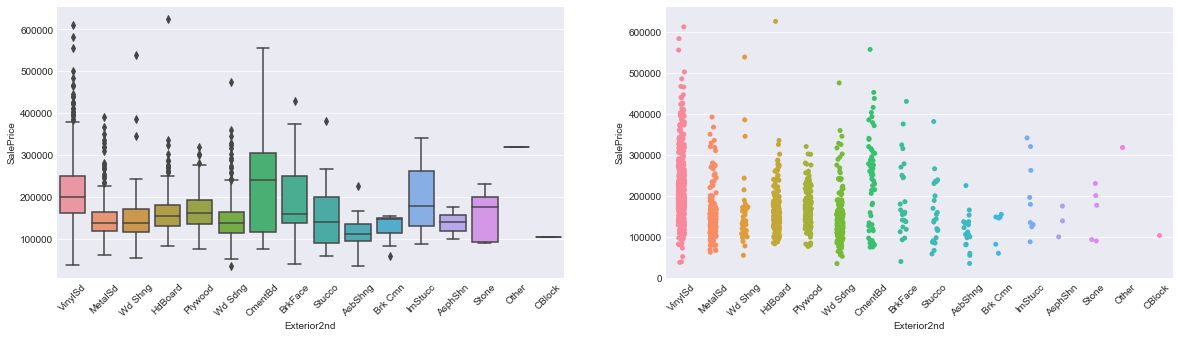

In [353]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Exterior2nd', y='SalePrice')

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='Exterior2nd', y='SalePrice', jitter=True)

### Foundation

Type of foundation.

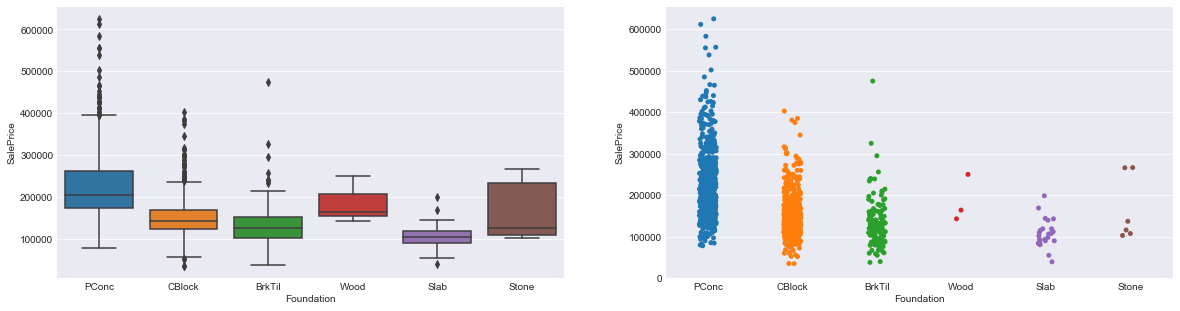

In [349]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Foundation', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='Foundation', y='SalePrice', jitter=True)

### Functional

Home functionality (Assume typical unless deductions are warranted).

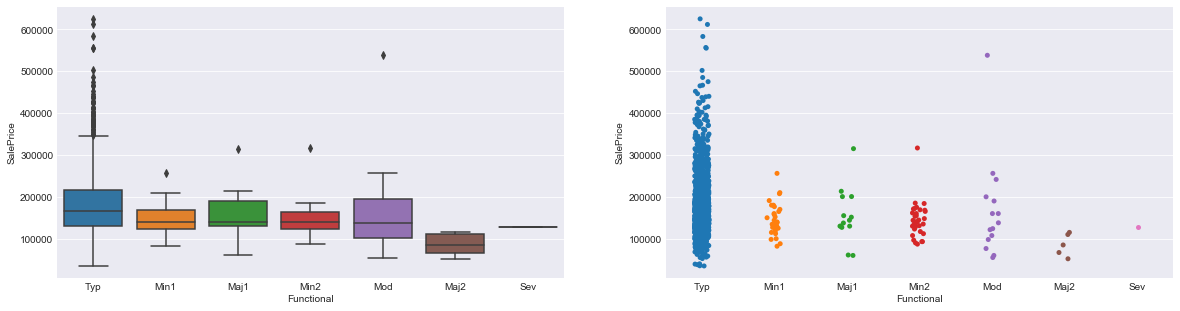

In [350]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Functional', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='Functional', y='SalePrice', jitter=True)

### GarageCond

Garage condition.

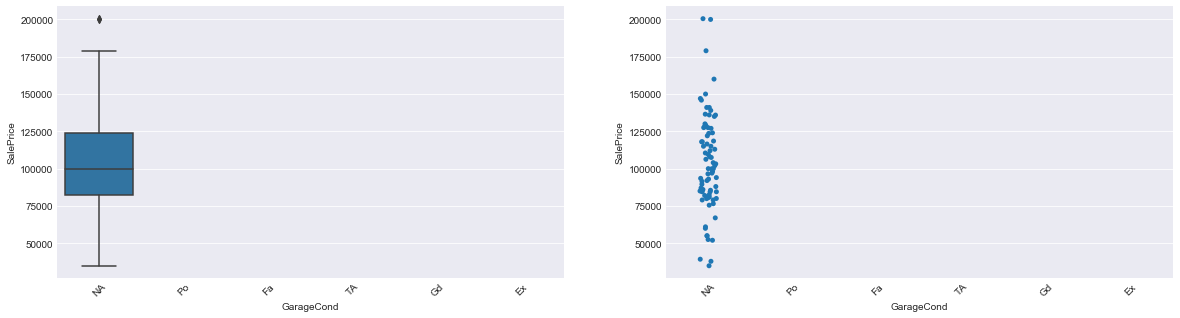

In [351]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='GarageCond', y='SalePrice', order=['NA','Po','Fa','TA','Gd','Ex'])

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='GarageCond', y='SalePrice', order=['NA','Po','Fa','TA','Gd','Ex'], jitter=True)

### GarageFinish

Interior finish of the garage: <br><br>
Fin - Finished <br>
RF - Rough Finished <br>
Unf - Unfinished <br>
NA - No Garage <br>

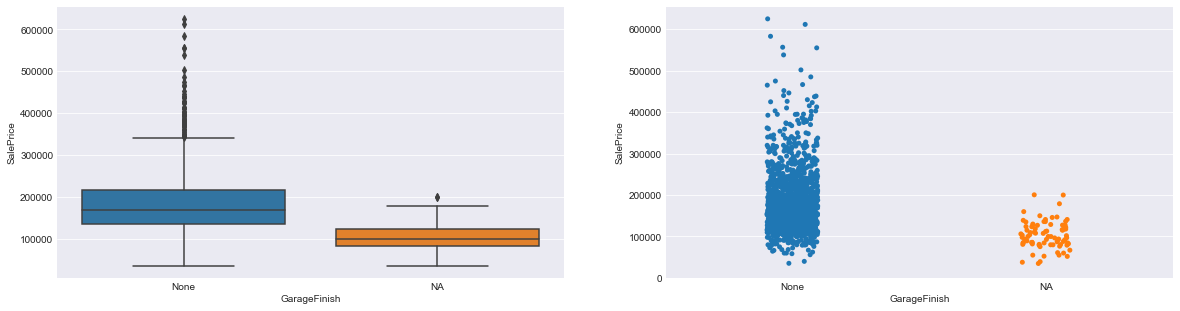

In [352]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='GarageFinish', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='GarageFinish', y='SalePrice', jitter=True)

### GarageQual

Garage condition.

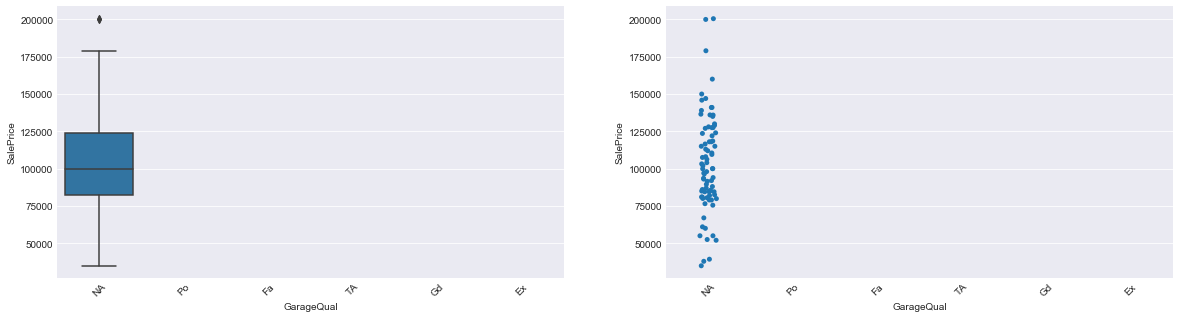

In [340]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='GarageQual', y='SalePrice', order=['NA','Po','Fa','TA','Gd','Ex'])

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='GarageQual', y='SalePrice', order=['NA','Po','Fa','TA','Gd','Ex'], jitter=True)

### GarageType

Garage location.

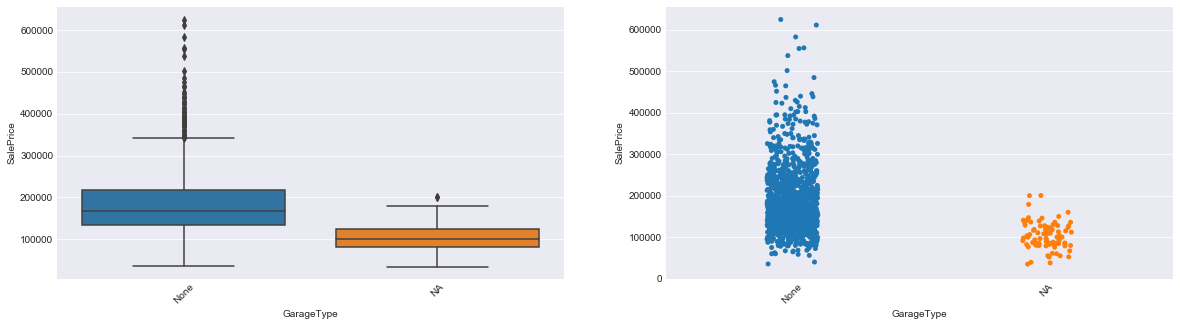

In [342]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='GarageType', y='SalePrice')

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='GarageType', y='SalePrice', jitter=True)

### Heating

Type of heating.

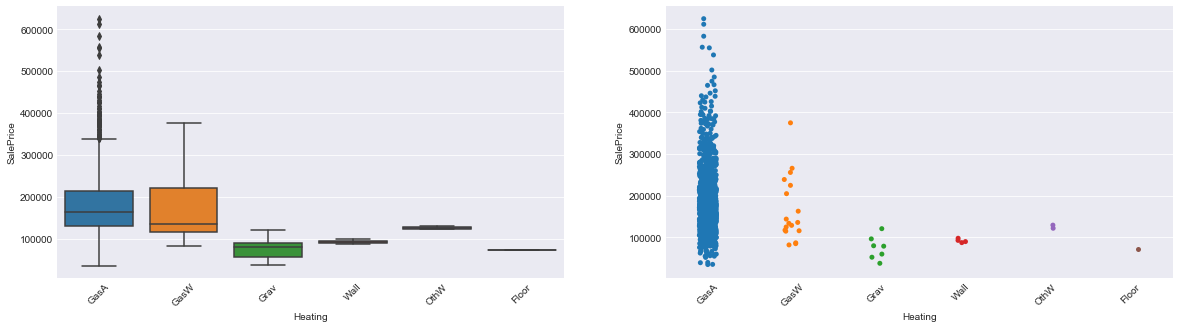

In [343]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Heating', y='SalePrice')

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='Heating', y='SalePrice', jitter=True)

### HeatingQC

Heating quality and condition

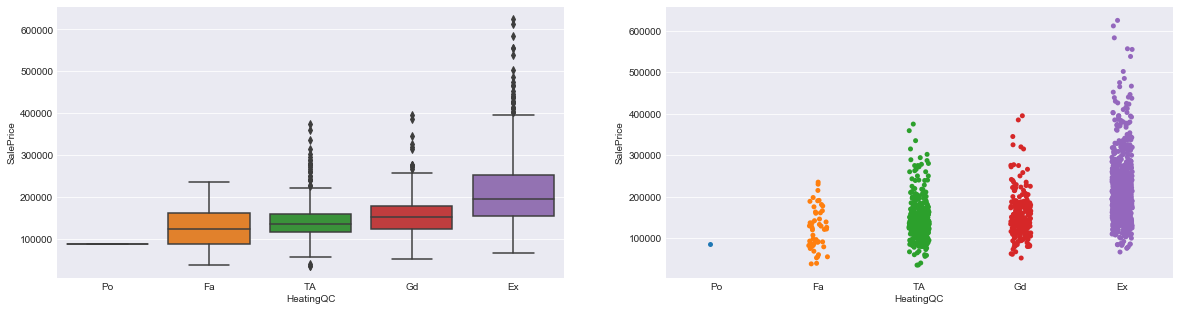

In [219]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='HeatingQC', y='SalePrice', order=['Po','Fa','TA','Gd','Ex'])

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='HeatingQC', y='SalePrice', jitter=True, order=['Po','Fa','TA','Gd','Ex'])

- HeatingQC has a positive correlation with SalePrice;
- Since it's an ordinal feature, i'm replacing the categories by hand;

In [220]:
all_data.replace({'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}, inplace=True)

### HouseStyle

Style of dwelling.

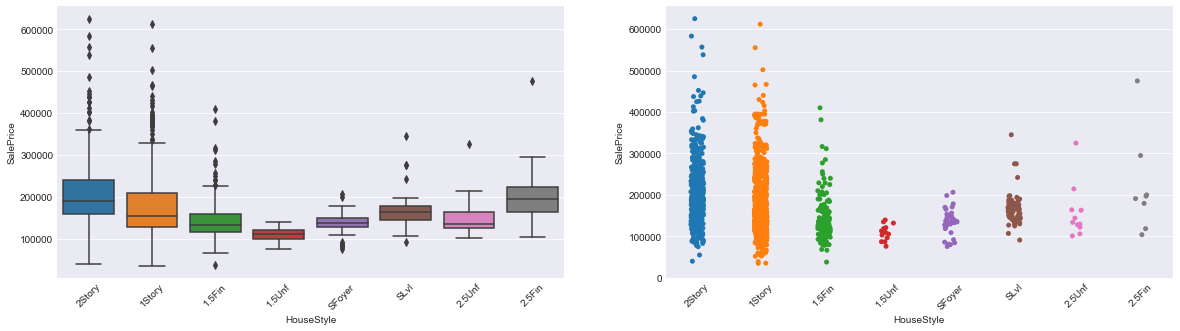

In [344]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='HouseStyle', y='SalePrice')

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='HouseStyle', y='SalePrice', jitter=True)

### KitchenQual

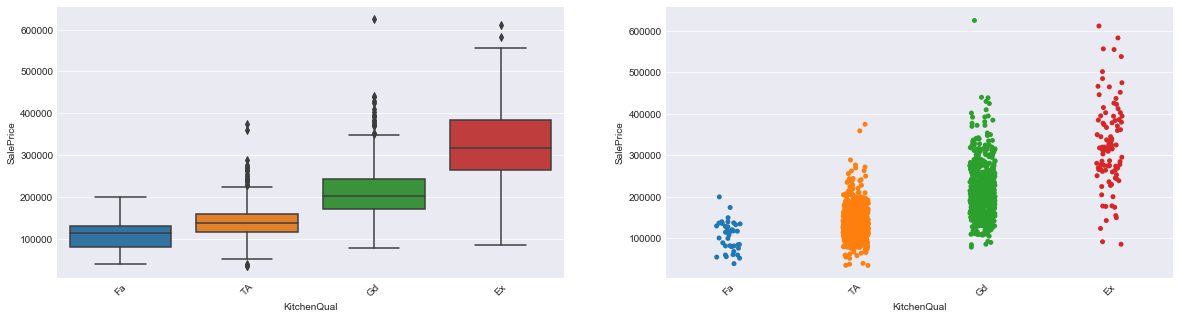

In [211]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='KitchenQual', y='SalePrice', order=['Fa','TA','Gd','Ex'])

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='KitchenQual', y='SalePrice', jitter=True, order=['Fa','TA','Gd','Ex'])

In [212]:
all_data.replace({'KitchenQual': {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}}, inplace=True)

### LandContour

Flatness of the property.

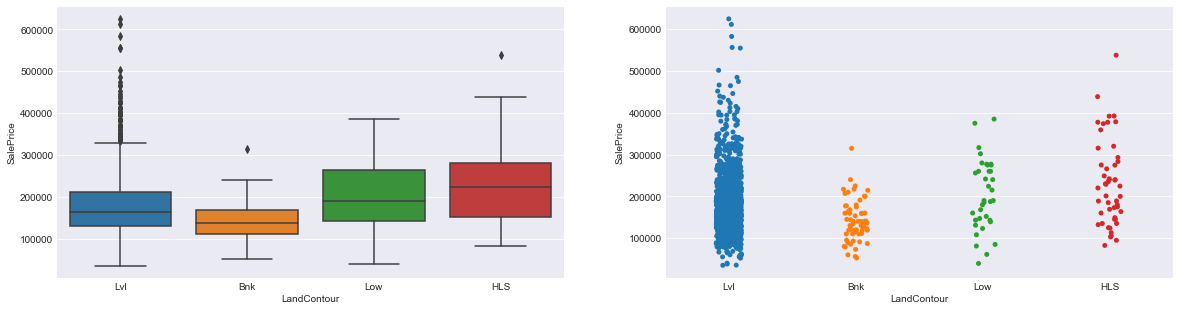

In [346]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='LandContour', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='LandContour', y='SalePrice', jitter=True)

### LandSlope

Slope of property.

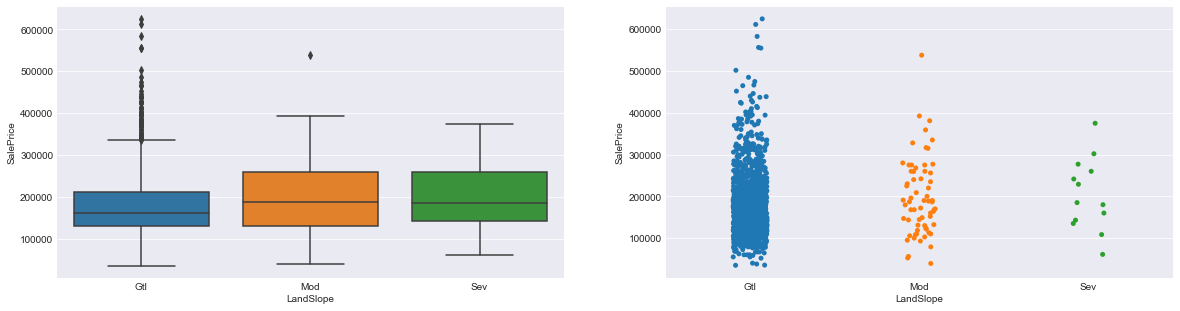

In [347]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='LandSlope', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='LandSlope', y='SalePrice', jitter=True)

### OverallQual

Rates the overall material and finish of the house.

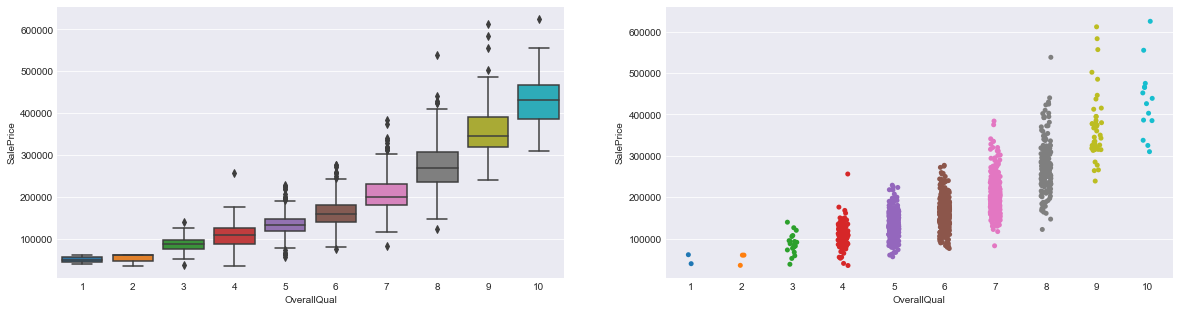

In [316]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='OverallQual', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='OverallQual', y='SalePrice', jitter=True)

### OverallCond

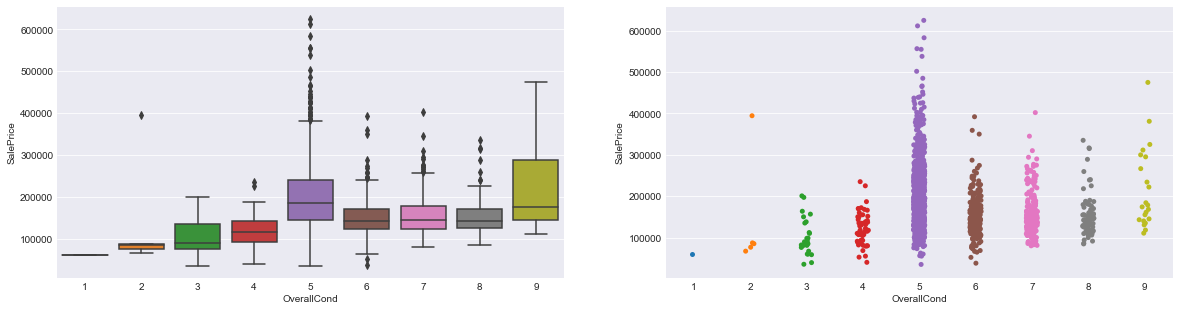

In [356]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='OverallCond', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='OverallCond', y='SalePrice', jitter=True)

### RoofMatl

Roof material.

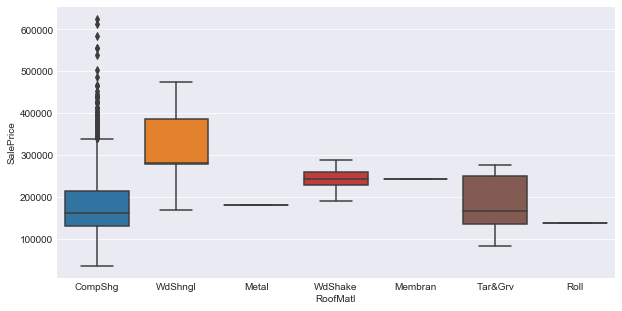

In [281]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='RoofMatl', y='SalePrice')

### Neighborhood

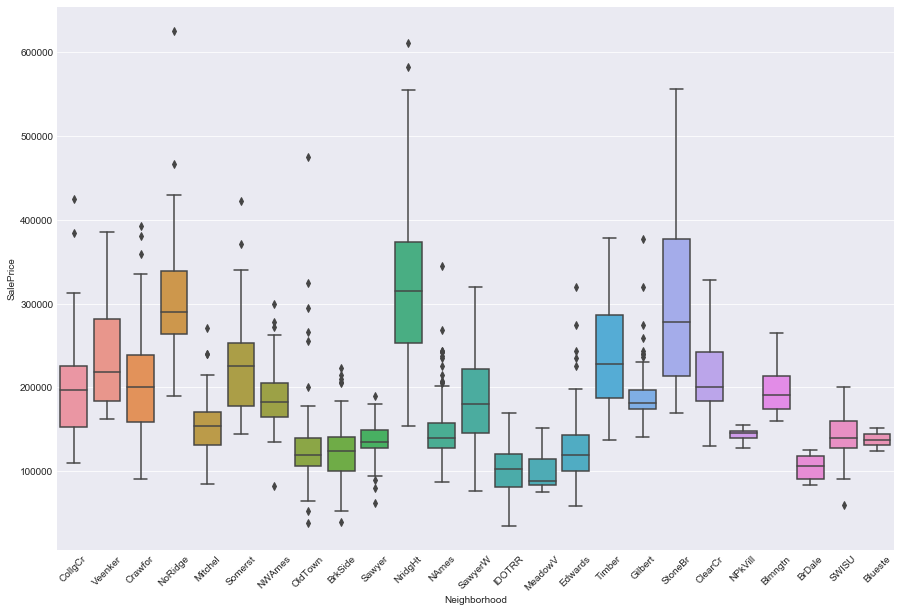

In [213]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Neighborhood', y='SalePrice')

In [214]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['Neighborhood'])

### SaleCondition

Condition of sale

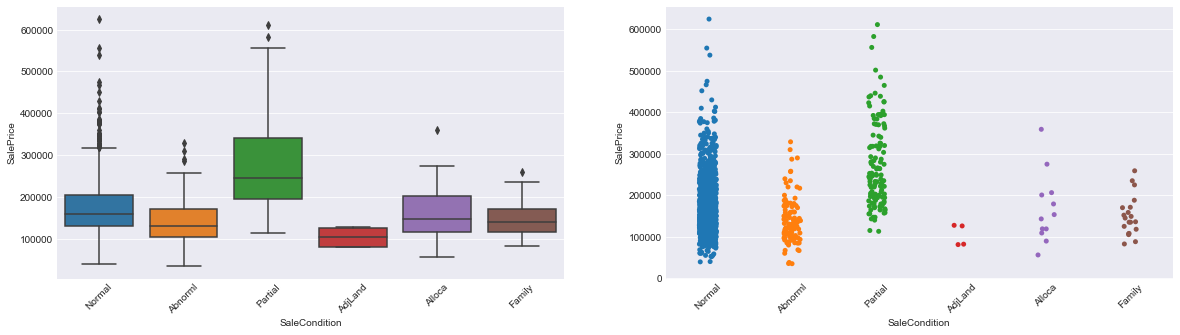

In [215]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='SaleCondition', y='SalePrice')

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='SaleCondition', y='SalePrice', jitter=True)

- Since there are only a few observations of AdjLand, Alloca and Family classes, i'm grouping all 3 in one new category called "Other";
- For the remaning three categories, i'm creating dummies because there is no order;

In [216]:
all_data.replace({'SaleCondition': {'AdjLand': 'Other', 
                                    'Alloca': 'Other', 
                                    'Family': 'Other'}}, inplace=True)
all_data = pd.get_dummies(all_data, drop_first=True, columns=['SaleCondition'])

### MSZoning

Identifies the general zoning classification of the sale.

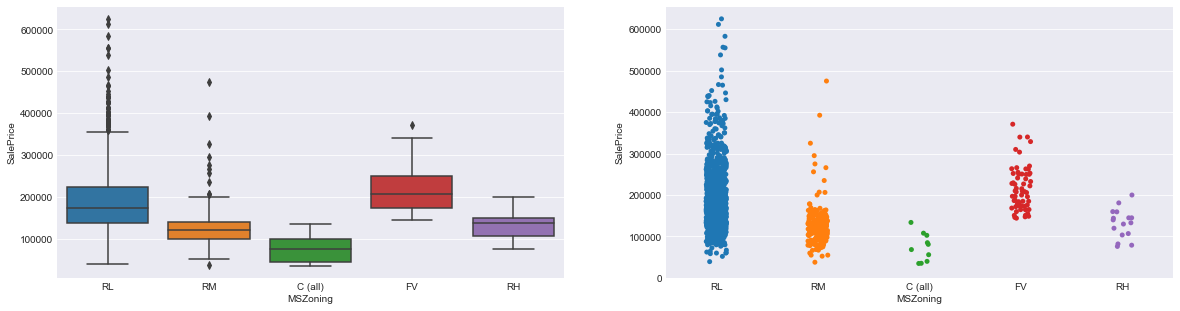

In [221]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='MSZoning', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='MSZoning', y='SalePrice', jitter=True)

In [222]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['MSZoning'])

---

## Feature Engineering

### HouseAge

This feature represents the age of the house in the moment of the sale, ie the difference between the year of sale and year of construction.

In [223]:
#all_data['HouseAge'] = all_data.apply(lambda x: x['YrSold'] - x['YearBuilt'] if x['YrSold'] >= x['YearBuilt'] else 0, axis=1)
all_data.drop(['YrSold'], axis=1, inplace=True)

In [224]:
#sns.jointplot(data=all_data[all_data['SalePrice'] > 0], x='HouseAge', y='SalePrice')

### Bathrooms

This feature represents the number of bathrooms in the house: <br>
<b>Bathrooms = FullBath + 0.5 HalfBath + BsmtFullBath + 0.5 BsmtHalfBath </b> <br>

In [225]:
all_data['Bathrooms'] = all_data['FullBath'] + \
                        all_data['HalfBath'] * 0.5 + \
                        all_data['BsmtFullBath'] + \
                        all_data['BsmtHalfBath'] * 0.5
all_data.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

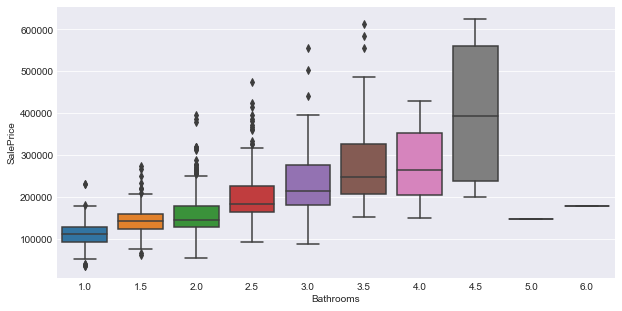

In [226]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Bathrooms', y='SalePrice')

### HasPool

Even though `PoolArea` isn't highly correlated with saleprice, a pool would certainly increase the price of a house, so I'm creating a flag to indicate if there's a pool or not.

In [227]:
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0).astype('uint8')
all_data.drop('PoolArea', axis=1, inplace=True)

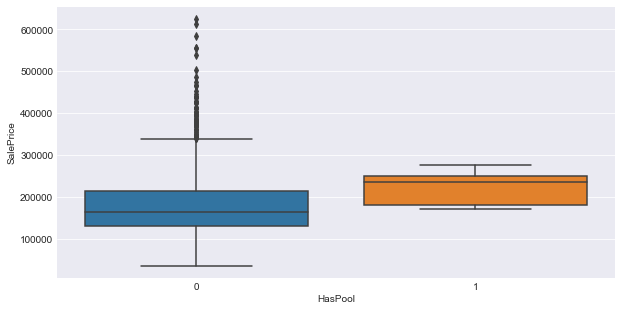

In [228]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='HasPool', y='SalePrice')

### HasBsmt

This feature represents the total finished square feet of basement area.

In [229]:
all_data['TotalBsmtSFFin'] = all_data['TotalBsmtSF'] - all_data['BsmtUnfSF']
all_data['HasBsmt'] = all_data['TotalBsmtSFFin'].apply(lambda x: 1 if x > 0 else 0).astype('uint8')
all_data.drop(['TotalBsmtSF', 'BsmtUnfSF', 'TotalBsmtSFFin'], axis=1, inplace=True)

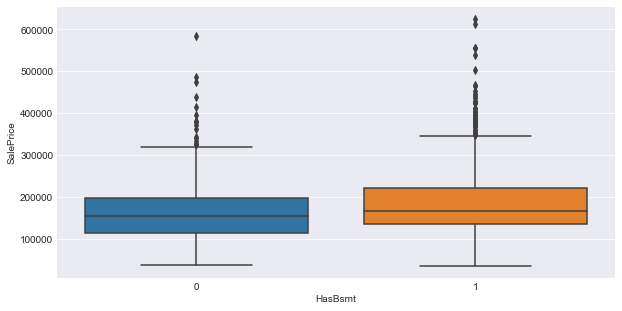

In [230]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='HasBsmt', y='SalePrice')

### Remodeled

This feature indicates if the house was remodeled or not.

In [231]:
all_data['Remodeled'] = (all_data['YearRemodAdd'] != all_data['YearBuilt']).astype('uint8')
all_data.drop(['YearRemodAdd'], axis=1, inplace=True)

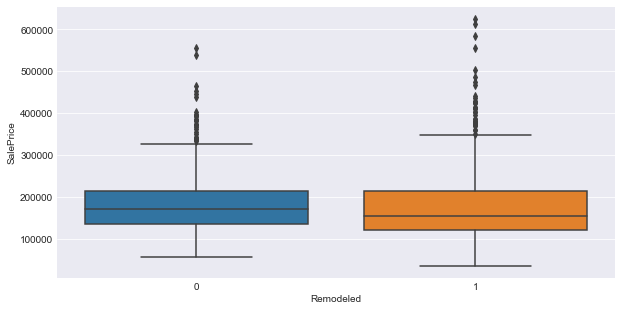

In [232]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Remodeled', y='SalePrice')

### OverallQC

This feature represents the relation between the quality and the condition.

In [233]:
all_data['OverallQC'] = all_data['OverallQual'] * all_data['OverallCond']
all_data.drop(['OverallQual','OverallCond'], axis=1, inplace=True)

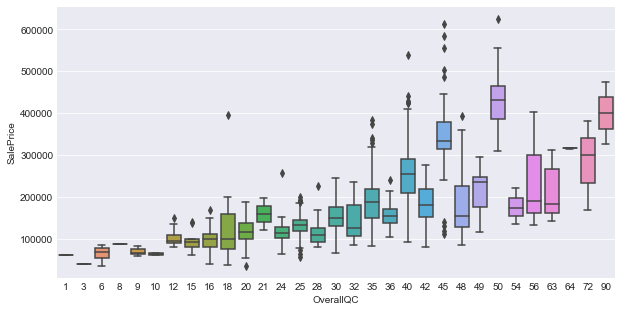

In [234]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='OverallQC', y='SalePrice')

In [235]:
all_data.drop(['MSSubClass',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'Electrical',
 'Functional',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType'], axis=1, inplace=True)

all_data.drop(['LotFrontage',
   'MasVnrArea',
   'BsmtFinSF1',
   'BsmtFinSF2',
   'LowQualFinSF',
   'BedroomAbvGr',
   'KitchenAbvGr',
   'TotRmsAbvGrd',
   'Fireplaces',
   'GarageArea',
   'WoodDeckSF',
   'OpenPorchSF',
   'EnclosedPorch',
   '3SsnPorch',
   'ScreenPorch',
   'MiscVal',
   'MoSold',
   '1stFlrSF',
   '2ndFlrSF'], axis=1, inplace=True)

---

## VIF

In [236]:
X = all_data.select_dtypes(exclude=['object']).assign(const=1)
X.drop('SalePrice', axis=1, inplace=True)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

GarageCars                   2.015210
GrLivArea                    2.254176
HeatingQC                    1.752260
KitchenQual                  2.133229
YearBuilt                    6.213599
ExterCond_Fa                 6.711512
ExterCond_Gd                23.773806
ExterCond_Po                 1.288955
ExterCond_TA                28.649587
Neighborhood_Blueste         1.471651
Neighborhood_BrDale          2.468066
Neighborhood_BrkSide         6.167103
Neighborhood_ClearCr         2.702686
Neighborhood_CollgCr         9.696057
Neighborhood_Crawfor         5.199677
Neighborhood_Edwards         8.309766
Neighborhood_Gilbert         6.671461
Neighborhood_IDOTRR          6.338504
Neighborhood_MeadowV         2.824500
Neighborhood_Mitchel         5.128559
Neighborhood_NAmes          16.127727
Neighborhood_NPkVill         1.907793
Neighborhood_NWAmes          5.863917
Neighborhood_NoRidge         3.591739
Neighborhood_NridgHt         6.679581
Neighborhood_OldTown        13.271765
Neighborhood

---

## Target Variable

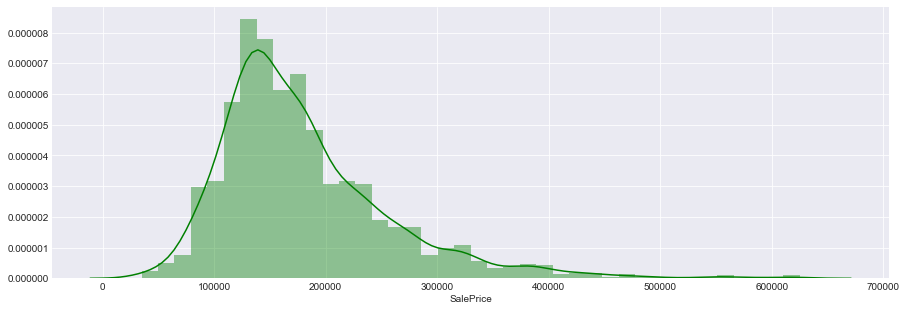

In [237]:
plt.figure(figsize=(15,5))
sns.distplot(all_data[all_data['SalePrice'] > 0]['SalePrice'], color='green')

- The target variable `SalePrice` is not normally distributed. A transformation will be required.

In [238]:
# Applying log transformation.
all_data.loc[all_data['SalePrice'] > 0, 'SalePrice'] = np.log(all_data.loc[all_data['SalePrice'] > 0, 'SalePrice'])

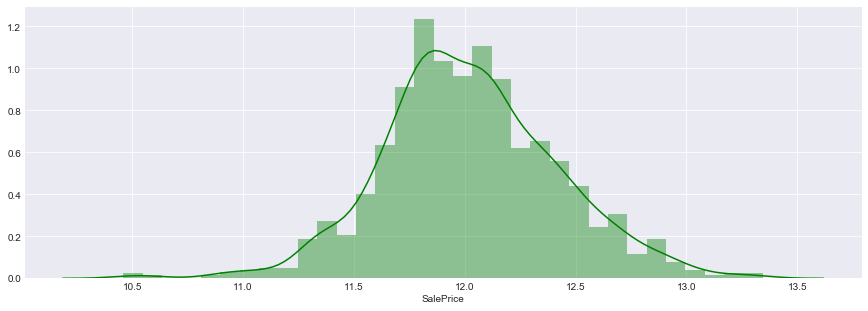

In [239]:
plt.figure(figsize=(15,5))
sns.distplot(all_data[all_data['SalePrice'] > 0]['SalePrice'], color='green')

---

## Skewed Features

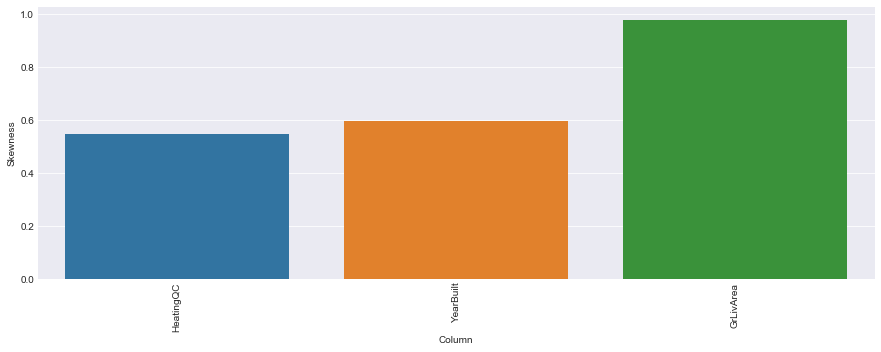

In [240]:
df_skew = pd.DataFrame(columns=['Column', 'Skewness'])

for feature in all_data.select_dtypes(exclude=['object','uint8']).columns:
    df_skew = df_skew.append({'Column': feature , 'Skewness': abs(skew(all_data[feature]))}, ignore_index=True)
df_skew = df_skew[df_skew['Skewness'] >= 0.5]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.barplot(data=df_skew.sort_values(by='Skewness'), x='Column', y='Skewness')

In [241]:
for feature in df_skew['Column']:
    all_data[feature] = np.log1p(all_data[feature])

---

## Model / Validation

### General Definitions

In [242]:
# Cross Validation Strategy...
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

# Score to be evaluated
scoring = 'neg_mean_squared_error'

### Train/Test Split

In [243]:
y_train = all_data.loc[all_data['SalePrice'] > 0, 'SalePrice']
X_train = all_data.loc[all_data['SalePrice'] > 0].drop('SalePrice', axis=1)
X_test = all_data.loc[all_data['SalePrice'] == 0].drop('SalePrice', axis=1)

print('Train Set: {}, {}'.format(X_train.shape[0], X_train.shape[1]))
print('Test Set: {}, {}'.format(X_test.shape[0], X_test.shape[1]))

Train Set: 1456, 46
Test Set: 1459, 46


In [244]:
X_train.columns

Index(['GarageCars', 'GrLivArea', 'HeatingQC', 'KitchenQual', 'YearBuilt',
       'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
       'SaleCondition_Normal', 'SaleCondition_Other', 'SaleCondition_Partial',
       'CentralAir_Y', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Bathrooms', 'HasPool', 'HasBsmt', 'Remodeled',
       'Overal

### Standartization

In [245]:
print('Scaling Features...')
scaler = RobustScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
print('Scaling OK')

Scaling Features...
Scaling OK


### Alpha (Regularization) Tuning

In [246]:
# Finding best value of Alpha
df_alphas = pd.DataFrame(columns=['Alpha', 'RMSE'])
alphas = []

for alpha in np.logspace(-10, 1, 300):
    
    list_mse = []
    rmse = 0
    model = Lasso(alpha=alpha, max_iter=1000)

    for train_index, test_index in cv.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_cv, y_train_cv)
        predictions = model.predict(X_test_cv)
        
        rmse = np.sqrt(mean_squared_error(y_test_cv, predictions))
        list_mse.append(rmse)
                                       
    df_alphas = df_alphas.append({'Alpha': alpha, 'RMSE': np.mean(list_mse)}, ignore_index=True)

df_alphas.sort_values(by='RMSE', inplace=True)
df_alphas.head()

,Alpha,RMSE
156,0.000055,0.131106
155,0.000050,0.131110
157,0.000060,0.131112
154,0.000046,0.131116
153,0.000043,0.131122


In [248]:
my_alpha = 0.00006
model = Lasso(alpha=my_alpha)

### Model Evaluation

#### RMSE

In [249]:
# Best So Far: 0.12057030209115657 - Kaggle: 0.13346
rmse = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)))
rmse

0.1311128844634095

#### Learning Curves

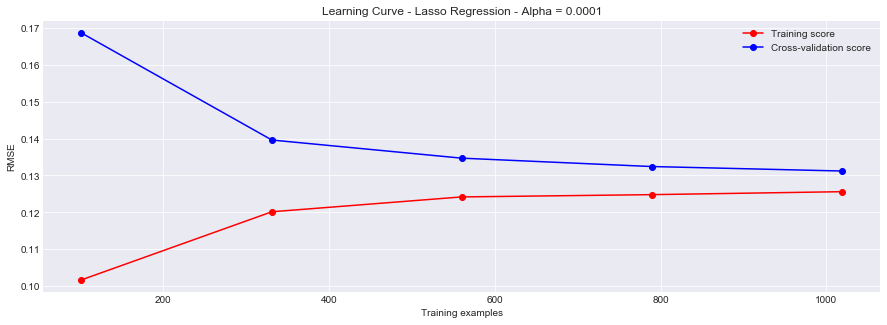

In [250]:
# Define train set sizes
train_sizes = np.linspace(.1, 1.0, 5)

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=cv, train_sizes=train_sizes, scoring=scoring)
train_rmse = np.sqrt(-np.mean(train_scores, axis=1))
cv_rmse = np.sqrt(-np.mean(test_scores, axis=1))

plt.figure(figsize=(15,5))
plt.title("Learning Curve - Lasso Regression - Alpha = %.4f" % my_alpha)
plt.xlabel("Training examples")
plt.ylabel("RMSE")
plt.plot(train_sizes, train_rmse, 'o-', color="r", label="Training score")
plt.plot(train_sizes, cv_rmse, 'o-', color="b", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [251]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
model.fit(X_train_cv, y_train_cv)
pred = model.predict(X_test_cv)

#### Real Values x Predictions

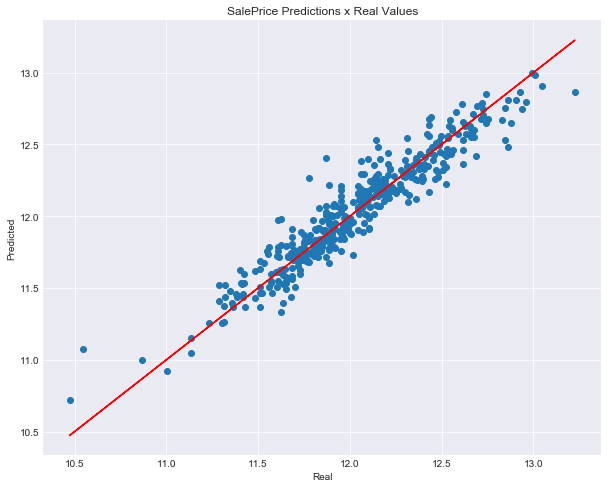

In [252]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(y_test_cv, pred)
ax.plot(y_test_cv, y_test_cv, c='r')
ax.set_title('SalePrice Predictions x Real Values')
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
fig.show()

In [253]:
check = pd.DataFrame(columns=['real_value', 'prediction', 'real_value_transformed', 'prediction_transformed'])
check['real_value'] = y_test_cv
check['prediction'] = pred
check['real_value_transformed'] = np.exp(check['real_value'])
check['prediction_transformed'] = np.exp(check['prediction'])
check[(check['real_value'] <= 12) & (check['prediction'] >= 12.1)]

,real_value,prediction,real_value_transformed,prediction_transformed
955,11.884489,12.215402,145000.0,201874.672354
962,11.951180,12.104879,155000.0,180751.600826
588,11.870600,12.405465,143000.0,244132.091615
959,11.951180,12.213195,155000.0,201429.622057
482,11.951180,12.186050,155000.0,196035.241853
714,11.779129,12.269605,130500.0,213118.888122
461,11.951180,12.140714,155000.0,187346.307699


In [183]:
df_train.loc[[588]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
588,589,20,RL,65.0,25095,Pave,NaN,IR1,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,5,8,1968,2003,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,Gd,GLQ,1324,Unf,0,113,1437,GasA,Ex,Y,SBrkr,1473,0,0,1473,2,0,1,0,1,1,Ex,5,Typ,2,Gd,Attchd,1968.0,Unf,1,452,TA,TA,Y,0,48,0,0,60,0,NaN,NaN,NaN,0,6,2009,WD,Partial,143000


#### Residuals

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


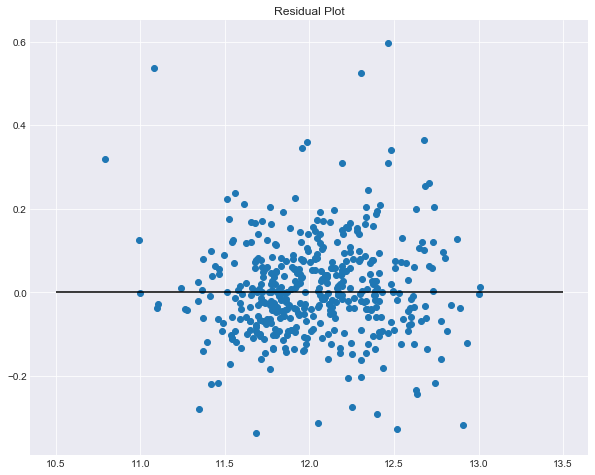

In [71]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(pred, pred - y_test_cv)
ax.hlines(y=0, xmin=10.5, xmax=13.5)
ax.set_title('Residual Plot')
fig.show()

In [72]:
list(zip(X_test_cv.columns, model.coef_))

[('GarageCars', 0.05278344822637534),
 ('GrLivArea', 0.18112711469397555),
 ('HeatingQC', 0.03700127813941478),
 ('KitchenQual', 0.040731859024825394),
 ('LotArea', 0.05441936468074816),
 ('YearBuilt', 0.14068050418631387),
 ('ExterCond_Fa', -0.004373965293625068),
 ('ExterCond_Gd', 0.04651202666705868),
 ('ExterCond_Po', -0.008221472241992935),
 ('ExterCond_TA', 0.07744497138722045),
 ('Neighborhood_Blueste', -0.0),
 ('Neighborhood_BrDale', -0.0543580975097855),
 ('Neighborhood_BrkSide', 0.045625136959599584),
 ('Neighborhood_ClearCr', 0.05318665438712454),
 ('Neighborhood_CollgCr', -0.0347515097916091),
 ('Neighborhood_Crawfor', 0.12886067579614188),
 ('Neighborhood_Edwards', -0.08525964697374334),
 ('Neighborhood_Gilbert', -0.08109618911527382),
 ('Neighborhood_IDOTRR', -0.02159684910889968),
 ('Neighborhood_MeadowV', -0.05811789395351736),
 ('Neighborhood_Mitchel', -0.07109471591321143),
 ('Neighborhood_NAmes', -0.03372031687838661),
 ('Neighborhood_NPkVill', 0.0),
 ('Neighborhood_

---

## Submission

In [73]:
model.fit(X_train, y_train)
sub_pred = model.predict(X_test)

In [74]:
submission['SalePrice'] = np.exp(sub_pred)
submission.to_csv('submission.csv',index=False)
submission.head()

,Id,SalePrice
0,1461,120657.840906
1,1462,161030.061794
2,1463,179481.111262
3,1464,203708.014626
4,1465,216699.635048


In [75]:
%%cmd
@echo off
#kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "13/03/2019 - Teste C/ OverallCond Dummy"
kaggle competitions submissions -c house-prices-advanced-regression-techniques

Microsoft Windows [versÆo 10.0.15063]
(c) 2017 Microsoft Corporation. Todos os direitos reservados.

c:\Projetos_Python\Kaggle\kaggle-house-prices-iowa>@echo off
#kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "13/03/2019 - Teste C/ OverallCond Dummy"
kaggle competitions submissions -c house-prices-advanced-regression-techniques
fileName        date                 description                                       status    publicScore  privateScore  
--------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
submission.csv  2019-03-14 00:33:32  13/03/2019 - Teste C/ OverallCond Dummy           complete  0.13436      None          
submission.csv  2019-03-13 22:12:17  13/03/2019 - Teste Removendo Outliers Diferentes  complete  0.13373      None          
submission.csv  2019-03-13 00:35:14  12/03/2019 - Teste c/ Remodeled                   complete  0.13346      None       

'#kaggle' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.
